# Import libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Read data in

In [33]:
tennis_data_list = []

for i in range(1994, 2024):
    
    tennis_data_list.append(pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_' + str(i) + '.csv'))

In [34]:
tennis = pd.concat(tennis_data_list, ignore_index = True)

#tennis = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv')
tennis.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1994-339,Adelaide,Hard,32,A,19940103,1,101404,1.0,NaN,...,30.0,17.0,15.0,8.0,10.0,14.0,9.0,NaN,97.0,NaN
1,1994-339,Adelaide,Hard,32,A,19940103,2,101917,NaN,NaN,...,37.0,25.0,17.0,13.0,1.0,6.0,86.0,NaN,NaN,NaN
2,1994-339,Adelaide,Hard,32,A,19940103,3,102158,NaN,NaN,...,39.0,23.0,14.0,10.0,9.0,13.0,66.0,NaN,NaN,NaN
3,1994-339,Adelaide,Hard,32,A,19940103,4,101601,8.0,NaN,...,34.0,21.0,6.0,8.0,4.0,8.0,43.0,NaN,84.0,NaN
4,1994-339,Adelaide,Hard,32,A,19940103,5,101120,3.0,NaN,...,35.0,24.0,12.0,9.0,2.0,5.0,17.0,NaN,222.0,NaN


Find all of the columns to operate on in the data.

In [35]:
tennis.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

Get only the relevant columns for calculating the statistics

In [36]:
tennis_players = tennis.loc[:, ["tourney_date", "winner_id", "winner_name", "winner_age",
                                "loser_id", "loser_name", "loser_age"]]

Convert the columns using functions for dat and age

In [37]:
def convert_columns(df):
    
    df_with_dates = convert_tourney_dates(df)
    
    df_amended_ages = get_player_ages(df_with_dates)
    
    return df_amended_ages

In [38]:
def convert_tourney_dates(df, date_column = "tourney_date"):
    
    df[date_column] = pd.to_datetime(df[date_column], format = "%Y%m%d")
    df["year"] = df[date_column].dt.year
    
    return tennis_players
    

In [39]:
def get_player_ages(df):
    
    # One of the players doesn't have an age
    tennis_players_complete = df[pd.isna(df["winner_age"]) == False]
    tennis_players_complete = tennis_players_complete[pd.isna(tennis_players_complete["loser_age"]) == False]
    
    tennis_players_complete["winner_age"] = tennis_players_complete["winner_age"].astype(int)
    tennis_players_complete["loser_age"] = tennis_players_complete["loser_age"].astype(int)
    
    return tennis_players_complete

In [40]:
tennis_players_complete = convert_columns(tennis_players)

# Wins and losses of big 3

In [41]:
def filter_players(df, winners, player_list):
     
    if winners == True:
        
        big_3 = df[df["winner_name"].isin(player_list)] 
        
    else:
        
        big_3 = df[df["loser_name"].isin(player_list)]
    
    return big_3
    

In [42]:
big_3 = ["Roger Federer", "Rafael Nadal", "Novak Djokovic"] 

big_3_winning = filter_players(tennis_players_complete, winners = True, player_list = big_3)
big_3_losing = filter_players(tennis_players_complete, winners = False, player_list = big_3)

Create mapping object for players and ID numbers

In [43]:
mapping_players = {"Roger Federer": 103819, "Novak Djokovic": 104925, "Rafael Nadal": 104745}

In [44]:
def get_wins_losses(df_win, df_loss):
    
    total_wins = count_wins_losses(df_win, winning = True)
    
    total_losses = count_wins_losses(df_loss, winning = False)
    
    all_wins_losses = pd.concat([total_wins, total_losses], axis = 1)
    
    all_wins_losses.columns = all_wins_losses.columns.droplevel()
    
    return all_wins_losses

In [45]:
def count_wins_losses(df, winning = True):
    
    if winning == True:
        total = (df.groupby(["winner_name", "winner_age"]).count()
                 .loc[:, ["tourney_date"]].unstack([0]).add_prefix("win_"))
        
    else:
        total = (df.groupby(["loser_name", "loser_age"]).count()
                 .loc[:, ["tourney_date"]].unstack([0]).add_prefix("lose_"))
        
    return total

In [46]:
all_wins_losses = get_wins_losses(big_3_winning, big_3_losing)

In [47]:
def calculate_win_pct(df, pct_list, win_list, loss_list):
    
    new_df = df.copy()
    
    for i, j, k in zip(pct_list, win_list, loss_list):
        
        new_df[i] = (new_df[j] / (new_df[j] + new_df[k])) * 100
        
    win_pct_data = new_df.loc["17":"39", pct_list]
        
    return win_pct_data
    

In [48]:
big_3_pct = ["Djokovic_win_pct", "Nadal_win_pct", "Federer_win_pct"]
big_3_win = ["win_Novak Djokovic", "win_Rafael Nadal", "win_Roger Federer"]
big_3_loss = ["lose_Novak Djokovic", "lose_Rafael Nadal", "lose_Roger Federer"]

win_big_3_percentage = calculate_win_pct(all_wins_losses, big_3_pct, big_3_win, big_3_loss)

# Visualisation

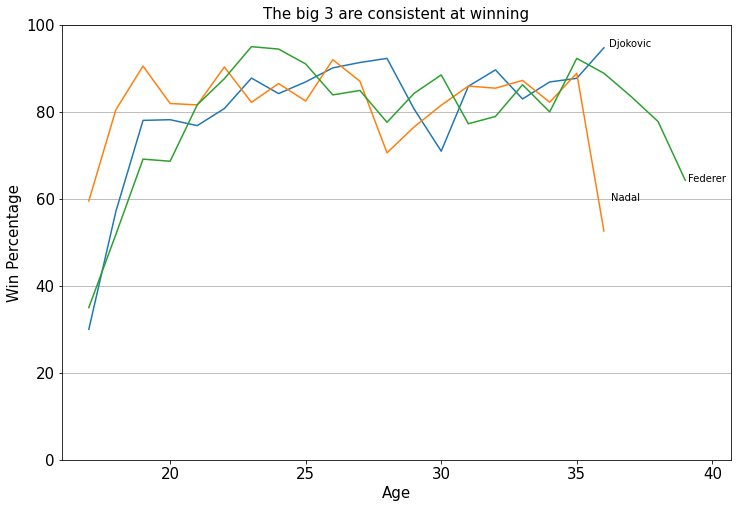

In [56]:
plt.figure(figsize = (12, 8))
plt.plot(win_big_3_percentage["Djokovic_win_pct"], label = "Djokovic")
plt.plot(win_big_3_percentage["Nadal_win_pct"], label = "Nadal")
plt.plot(win_big_3_percentage["Federer_win_pct"], label = "Federer")
#plt.plot(win_sampras_percentage["Sampras_win_pct"], label = "Sampras")
plt.xlim(16, 40.7)
plt.ylim(0, 100)
#plt.legend()
plt.grid(axis = "y")
plt.xlabel("Age", fontsize = 15)
plt.ylabel("Win Percentage", fontsize = 15)
plt.title("The big 3 are consistent at winning", fontsize = 15)
plt.annotate("Federer", (39.1, 64))
plt.annotate("Nadal", (36.25, 59.5))
plt.annotate("Djokovic", (36.2, 95))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

# Other players

In [311]:
murray_win = filter_players(df = tennis_players_complete, winners = True, player_list = ["Andy Murray"])
murray_loss = filter_players(df = tennis_players_complete, winners = False, player_list = ["Andy Murray"])

In [312]:
murray_wins_losses = get_wins_losses(murray_win, murray_loss)

In [313]:
win_murray_percentage = calculate_win_pct(murray_wins_losses, ["Murray_win_pct"],
                                          ["win_Andy Murray"], ["lose_Andy Murray"])

Sampras

In [318]:
average_win_big_3 = win_big_3_percentage.copy()

In [319]:
average_win_big_3["Average_win_pct"] = ((average_win_big_3["Djokovic_win_pct"] + 
                                       average_win_big_3["Nadal_win_pct"] + 
                                       average_win_big_3["Federer_win_pct"]) / 3)

# Look at historically good players

In [353]:
historical_list = ["Pete Sampras", "Ivan Lendl", "Mats Wilander", "Andre Agassi", "Thomas Muster", "Boris Becker"]

historical_win = filter_players(df = tennis_players_complete, winners = True, player_list = historical_list)
historical_loss = filter_players(df = tennis_players_complete, winners = False, player_list = historical_list)

In [354]:
historical_wins_losses = get_wins_losses(historical_win, historical_loss)

In [355]:
historical_wins_losses

winner_name,win_Andre Agassi,win_Boris Becker,win_Ivan Lendl,win_Mats Wilander,win_Pete Sampras,win_Thomas Muster,lose_Andre Agassi,lose_Boris Becker,lose_Ivan Lendl,lose_Mats Wilander,lose_Pete Sampras,lose_Thomas Muster
15,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN
16,11.0,7.0,NaN,5.0,5.0,3.0,10.0,9.0,NaN,9.0,4.0,2.0
17,38.0,56.0,NaN,46.0,18.0,12.0,16.0,19.0,NaN,19.0,19.0,8.0
18,54.0,70.0,NaN,77.0,36.0,22.0,12.0,14.0,NaN,14.0,18.0,17.0
19,47.0,56.0,7.0,53.0,45.0,24.0,16.0,15.0,4.0,10.0,19.0,18.0
20,42.0,52.0,111.0,71.0,75.0,48.0,16.0,10.0,27.0,19.0,21.0,15.0
21,41.0,64.0,102.0,72.0,82.0,22.0,18.0,8.0,12.0,17.0,16.0,9.0
22,43.0,77.0,103.0,63.0,84.0,51.0,12.0,16.0,11.0,15.0,11.0,18.0
23,33.0,50.0,72.0,55.0,64.0,32.0,12.0,13.0,15.0,14.0,17.0,21.0
24,66.0,52.0,57.0,43.0,70.0,36.0,12.0,16.0,15.0,18.0,15.0,20.0


In [356]:
historical_win_pct = ["Sampras_win_pct", "Lendl_win_pct", "Wilander_win_pct", "Agassi_win_pct",
                      "Muster_win_pct", "Becker_win_pct"]

historical_win = ["win_Pete Sampras", "win_Ivan Lendl", "win_Mats Wilander",
                  "win_Andre Agassi", "win_Thomas Muster", "win_Boris Becker"]

historical_loss = ["lose_Pete Sampras", "lose_Ivan Lendl", "lose_Mats Wilander",
                   "lose_Andre Agassi", "lose_Thomas Muster", "lose_Boris Becker"]

win_historical_percentage = calculate_win_pct(historical_wins_losses, historical_win_pct,
                                           historical_win, historical_loss)

In [357]:
win_historical_percentage

winner_name,Sampras_win_pct,Lendl_win_pct,Wilander_win_pct,Agassi_win_pct,Muster_win_pct,Becker_win_pct
17,48.648649,NaN,70.769231,70.370370,60.000000,74.666667
18,66.666667,NaN,84.615385,81.818182,56.410256,83.333333
19,70.312500,63.636364,84.126984,74.603175,57.142857,78.873239
20,78.125000,80.434783,78.888889,72.413793,76.190476,83.870968
21,83.673469,89.473684,80.898876,69.491525,70.967742,88.888889
22,88.421053,90.350877,80.769231,78.181818,73.913043,82.795699
23,79.012346,82.758621,79.710145,73.333333,60.377358,79.365079
24,82.352941,79.166667,70.491803,84.615385,64.285714,76.470588
25,85.135135,94.230769,55.172414,84.722222,76.530612,66.666667
26,80.281690,89.473684,55.555556,63.414634,71.951220,74.242424


# Visualise v historic players

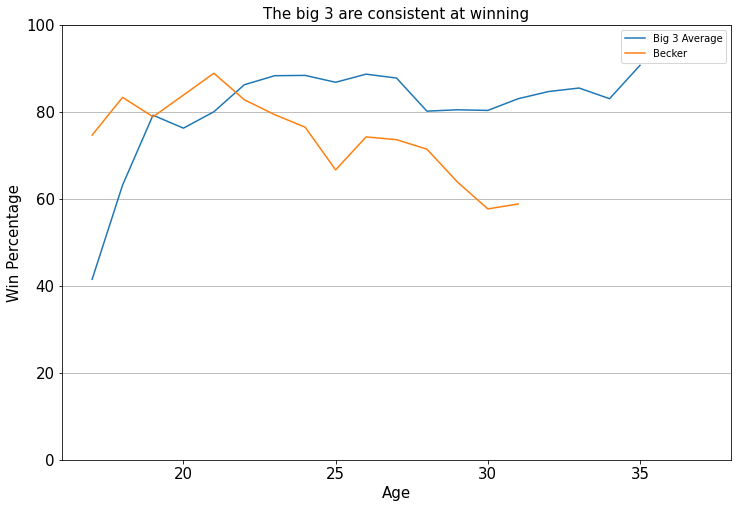

In [360]:
plt.figure(figsize = (12, 8))
plt.plot(average_win_big_3["Average_win_pct"], label = "Big 3 Average")
plt.plot(win_historical_percentage["Becker_win_pct"], label = "Becker")
#plt.plot(win_big_3_percentage["Federer_win_pct"], label = "Federer")
#plt.plot(win_sampras_percentage["Sampras_win_pct"], label = "Sampras")
plt.xlim(16, 38)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis = "y")
plt.xlabel("Age", fontsize = 15)
plt.ylabel("Win Percentage", fontsize = 15)
plt.title("The big 3 are consistent at winning", fontsize = 15)
#plt.annotate("Federer", (39.1, 64))
#plt.annotate("Nadal", (36.25, 61.5))
#plt.annotate("Djokovic", (33, 90))
plt.xticks([20, 25, 30, 35], fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

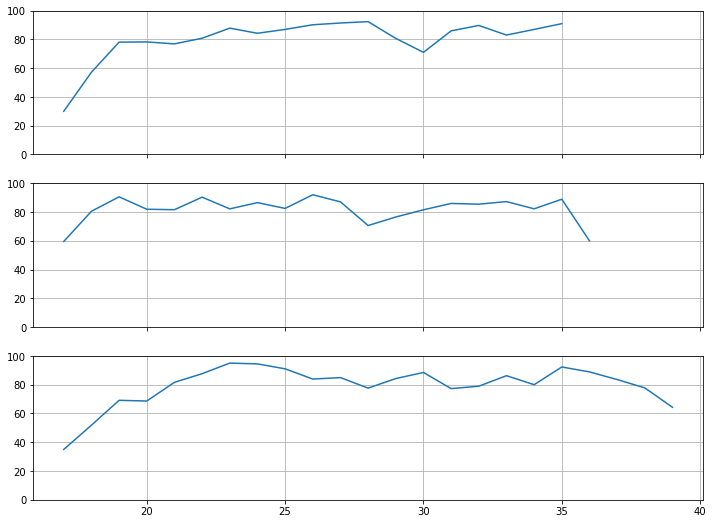

In [224]:
fig, ax = plt.subplots(3, sharex = True)
ax[0].plot(win_big_3_percentage["Djokovic_win_pct"])
ax[0].grid()
ax[0].set_ylim(0, 100)
ax[1].plot(win_big_3_percentage["Nadal_win_pct"])
ax[1].set_ylim(0, 100)
ax[1].grid()
ax[2].plot(win_big_3_percentage["Federer_win_pct"])
ax[2].set_ylim(0, 100)
ax[2].grid()
fig.set_figheight(9)
fig.set_figwidth(12)
